In [1]:
import torch

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
import os
from PIL import Image

data_dir = 'data'

target_size = (32, 32)

for dir_name in os.listdir(data_dir):
    dir_path = os.path.join(data_dir, dir_name)
    if os.path.isdir(dir_path):
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            with Image.open(img_path) as img:
                img_resized = img.resize(target_size)
                img_resized.save(img_path) 

In [6]:
import torch.nn as nn

class DiscriminatorNet(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding="same")  # 3 inputy, 32 outputow, 4x4 kernel
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding="same")
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 4, stride=2, padding="same")
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.lrelu = nn.LeakyReLU(negative_slope=0.01)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        x = self.lrelu(self.bn3(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [29]:
class GeneratorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 64 * 4 * 4)
        self.conv1 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 256, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 3, 5, padding="same")
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 64, 4, 4)
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.lrelu(self.conv3(x))
        x = self.conv4(x)
        x = self.tanh(x)

        return x

In [8]:
def noise(size): 
    return torch.randn(size, 64) # size x 64

In [ ]:
generator = GeneratorNet()
generator.to(device)

In [32]:
import matplotlib.pyplot as plt

def show_generated_image(img):
    img = img.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img + 1) / 2
    img = (img * 255).astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

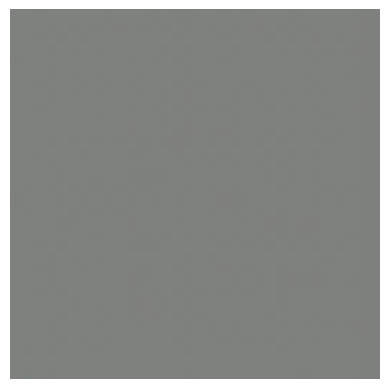

In [39]:
generator.eval()

with torch.no_grad():
    img = generator(noise(1).to(device))
    show_generated_image(img)

generator.train()
pass  # avoid print

In [46]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder('data/real_cakes', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)

In [47]:
dataiter = iter(dataloader)

In [52]:
def show_images(images):
    fig = plt.figure(figsize=(16, 8))
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2
        img = (img * 255).astype('uint8')
        ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(img)
    plt.show()

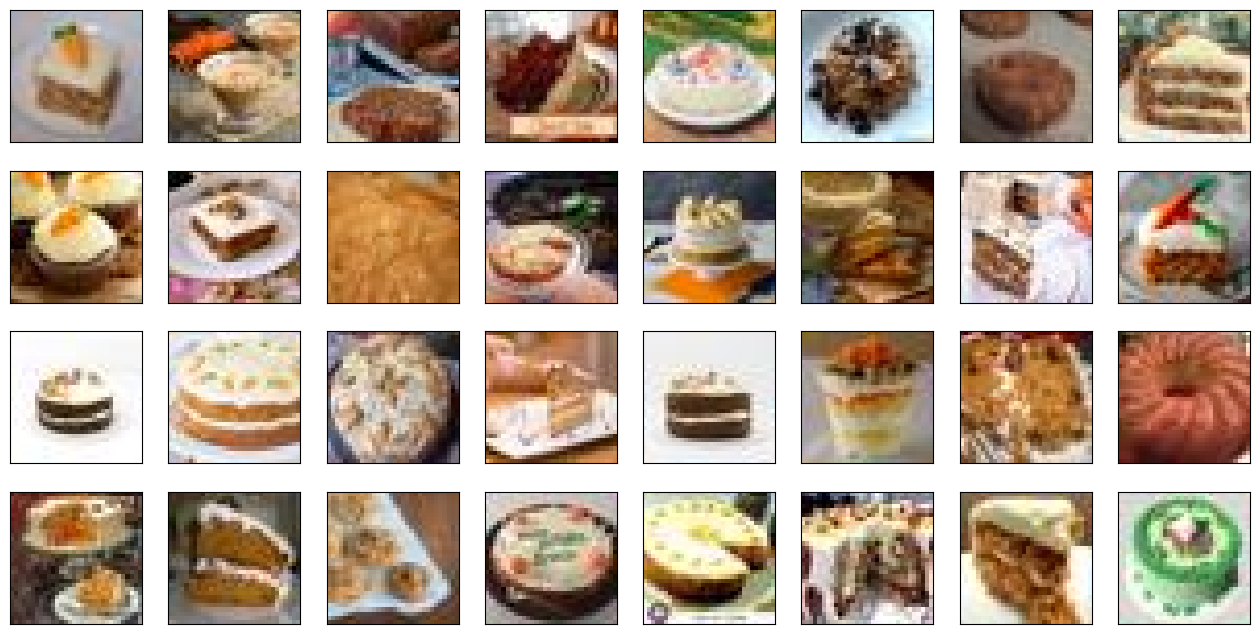

In [53]:
images, _ = next(dataiter)
show_images(images)